# COVID-19 pandemic data analysis

### Obtain data from John Hopkins CSSE repository 

Using @GaelVaroquaux [`covid-dashboard`](https://github.com/covid19-dash/covid-dashboard) helpers

In [1]:
import sys
import matplotlib.pyplot as plt

sys.path.insert(0, "./covid-dashboard/")

In [2]:
import data_input

data = data_input.get_data()

In [3]:
data

type             confirmed                                              \
iso                    AFG    AGO     ALB     AND                  ARE   
country_region Afghanistan Angola Albania Andorra United Arab Emirates   
date                                                                     
2020-01-22               0      0       0       0                    0   
2020-01-23               0      0       0       0                    0   
2020-01-24               0      0       0       0                    0   
2020-01-25               0      0       0       0                    0   
2020-01-26               0      0       0       0                    0   
...                    ...    ...     ...     ...                  ...   
2020-05-05            3224     36     820     751                15192   
2020-05-06            3392     36     832     751                15738   
2020-05-07            3563     36     842     752                16240   
2020-05-08            3778     43     850     752                16793   
2020-05-09            4033     43     856     754                17417   

type                                                                    ...  \
iso                  ARG     ARM                 ATG       AUS     AUT  ...   
country_region Argentina Armenia Antigua and Barbuda Australia Austria  ...   
date                                                                    ...   
2020-01-22             0       0                   0         0       0  ...   
2020-01-23             0       0                   0         0       0  ...   
2020-01-24             0       0                   0         0       0  ...   
2020-01-25             0       0                   0         0       0  ...   
2020-01-26             0       0                   0         4       0  ...   
...                  ...     ...                 ...       ...     ...  ...   
2020-05-05          5020    2619                  25      6875   15650  ...   
2020-05-06          5208    2782                  25      6894   15684  ...   
2020-05-07          5371    2884                  25      6913   15752  ...   
2020-05-08          5611    3029                  25      6918   15774  ...   
2020-05-09          5776    3175                  25      6939   15833  ...   

type             death                           \
iso                URY           USA        UZB   
country_region Uruguay United States Uzbekistan   
date                                              
2020-01-22           0             0          0   
2020-01-23           0             0          0   
2020-01-24           0             0          0   
2020-01-25           0             0          0   
2020-01-26           0             0          0   
...                ...           ...        ...   
2020-05-05          17         71064         10   
2020-05-06          17         73455         10   
2020-05-07          17         75662         10   
2020-05-08          18         77180         10   
2020-05-09          18         78795         10   

type                                                                     \
iso                                         VCT       VEN     VNM   YEM   
country_region Saint Vincent and the Grenadines Venezuela Vietnam Yemen   
date                                                                      
2020-01-22                                    0         0       0     0   
2020-01-23                                    0         0       0     0   
2020-01-24                                    0         0       0     0   
2020-01-25                                    0         0       0     0   
2020-01-26                                    0         0       0     0   
...                                         ...       ...     ...   ...   
2020-05-05                                    0        10       0     4   
2020-05-06                                    0        10       0     5   
2020-05-07                           

### Select countries of interest and retrieve confirmed cases and deaths dataframes

In [4]:
COUNTRIES = ["ESP", "GBR", "DEU", "AUT"]

In [5]:
confirmed = data["confirmed"][COUNTRIES]
dead = data["death"][COUNTRIES]

Text(0.5, 1.0, 'Log-scale plot of number of confirmed cases')

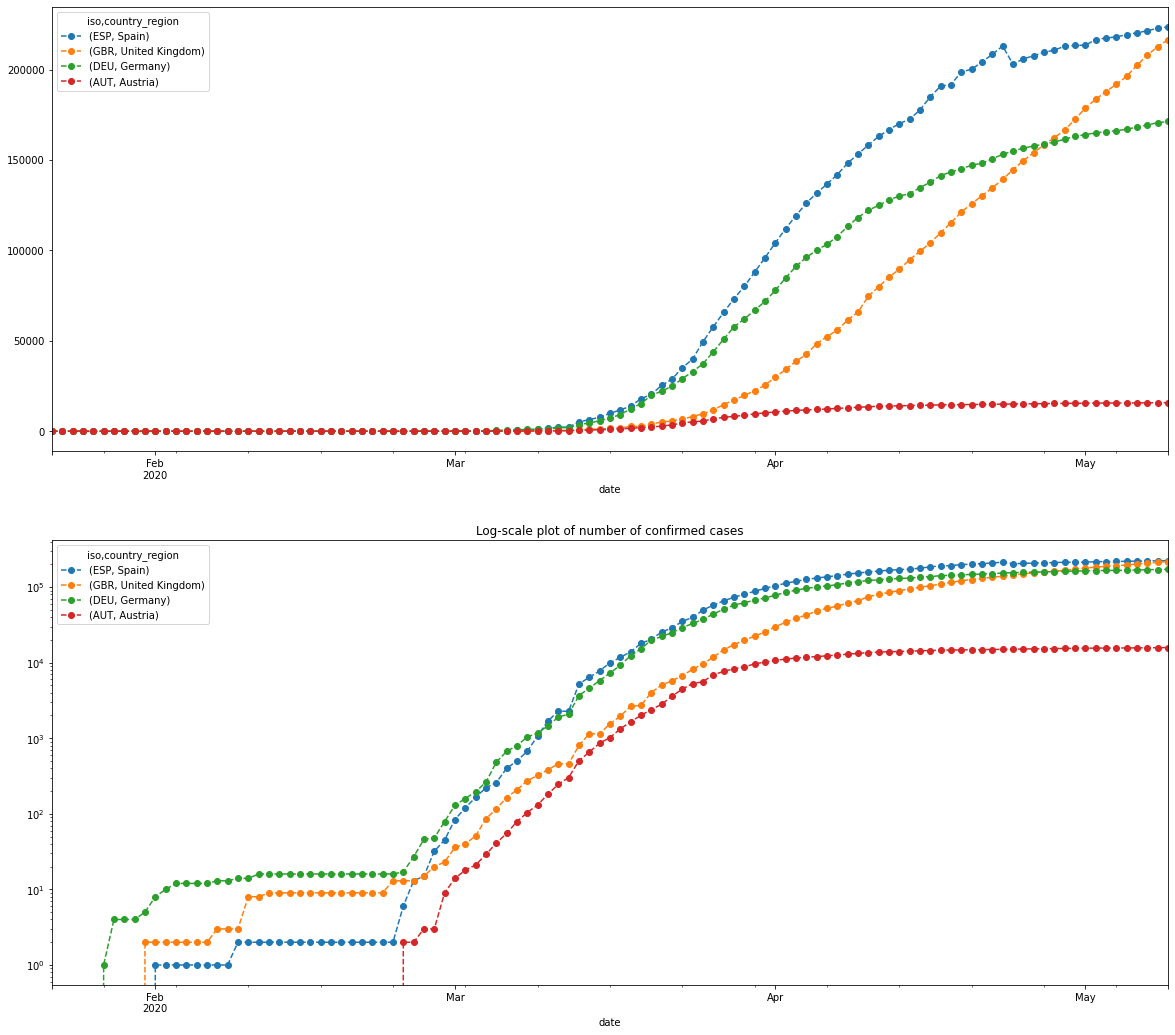

In [6]:
fig, (top_ax, bottom_ax) = plt.subplots(2, 1, figsize=(20, 18))
confirmed.plot(ax=top_ax, linestyle="--", marker="o")
confirmed.plot(ax=bottom_ax, linestyle="--", marker="o")
bottom_ax.set_yscale("log")
bottom_ax.set_title("Log-scale plot of number of confirmed cases")

Text(0.5, 1.0, 'Log-scale plot of number of total deaths (daily confirmed)')

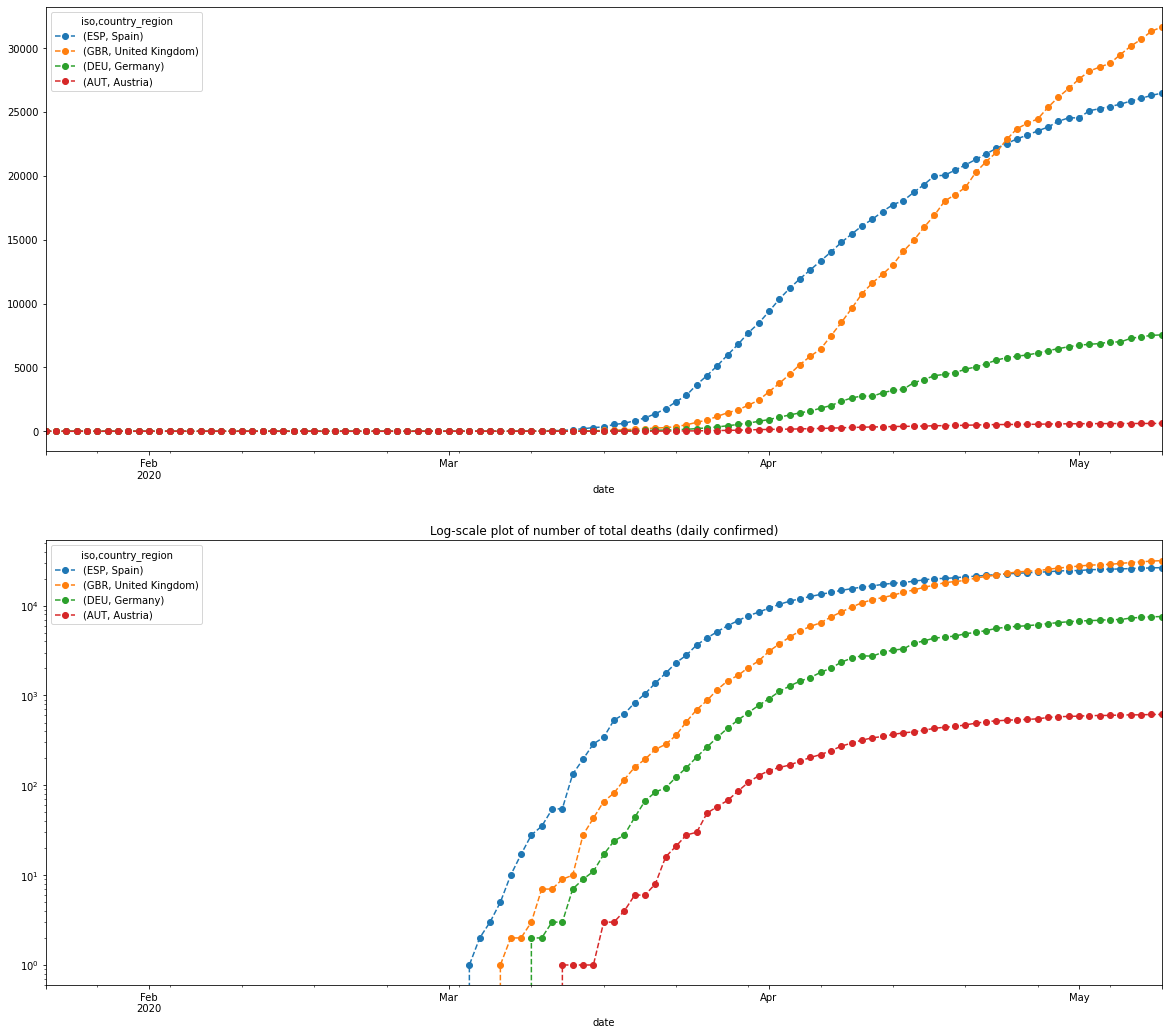

In [7]:
fig, (top_ax, bottom_ax) = plt.subplots(2, 1, figsize=(20, 18))
dead.plot(ax=top_ax, linestyle="--", marker="o")
dead.plot(ax=bottom_ax, linestyle="--", marker="o")
bottom_ax.set_yscale("log")
bottom_ax.set_title("Log-scale plot of number of total deaths (daily confirmed)")

## Detailed analysis for UK and Spain and predictions

In [8]:
# Base Data
confirmed = confirmed[["ESP", "GBR"]]
dead = dead[["ESP", "GBR"]]
last_day = confirmed.iloc[-1]
countries_of_interest = confirmed.columns[last_day.argsort()][::-1]
growth_rate = confirmed.pct_change()
abs_growth_confirmed = confirmed.diff()
abs_growth_deaths = dead.diff()

In [9]:
# Derived Data for plots
date_lockdown_ES = "2020-03-14"
date_lockdown_UK = "2020-03-23"
idx_lockdown_ES = confirmed.index.get_loc(date_lockdown_ES)
idx_lockdown_UK = confirmed.index.get_loc(date_lockdown_UK)

confirmed_on_lockdown_ES = abs_growth_confirmed["ESP"].iloc[idx_lockdown_ES]
confirmed_on_lockdown_UK = abs_growth_confirmed["GBR"].iloc[idx_lockdown_UK]

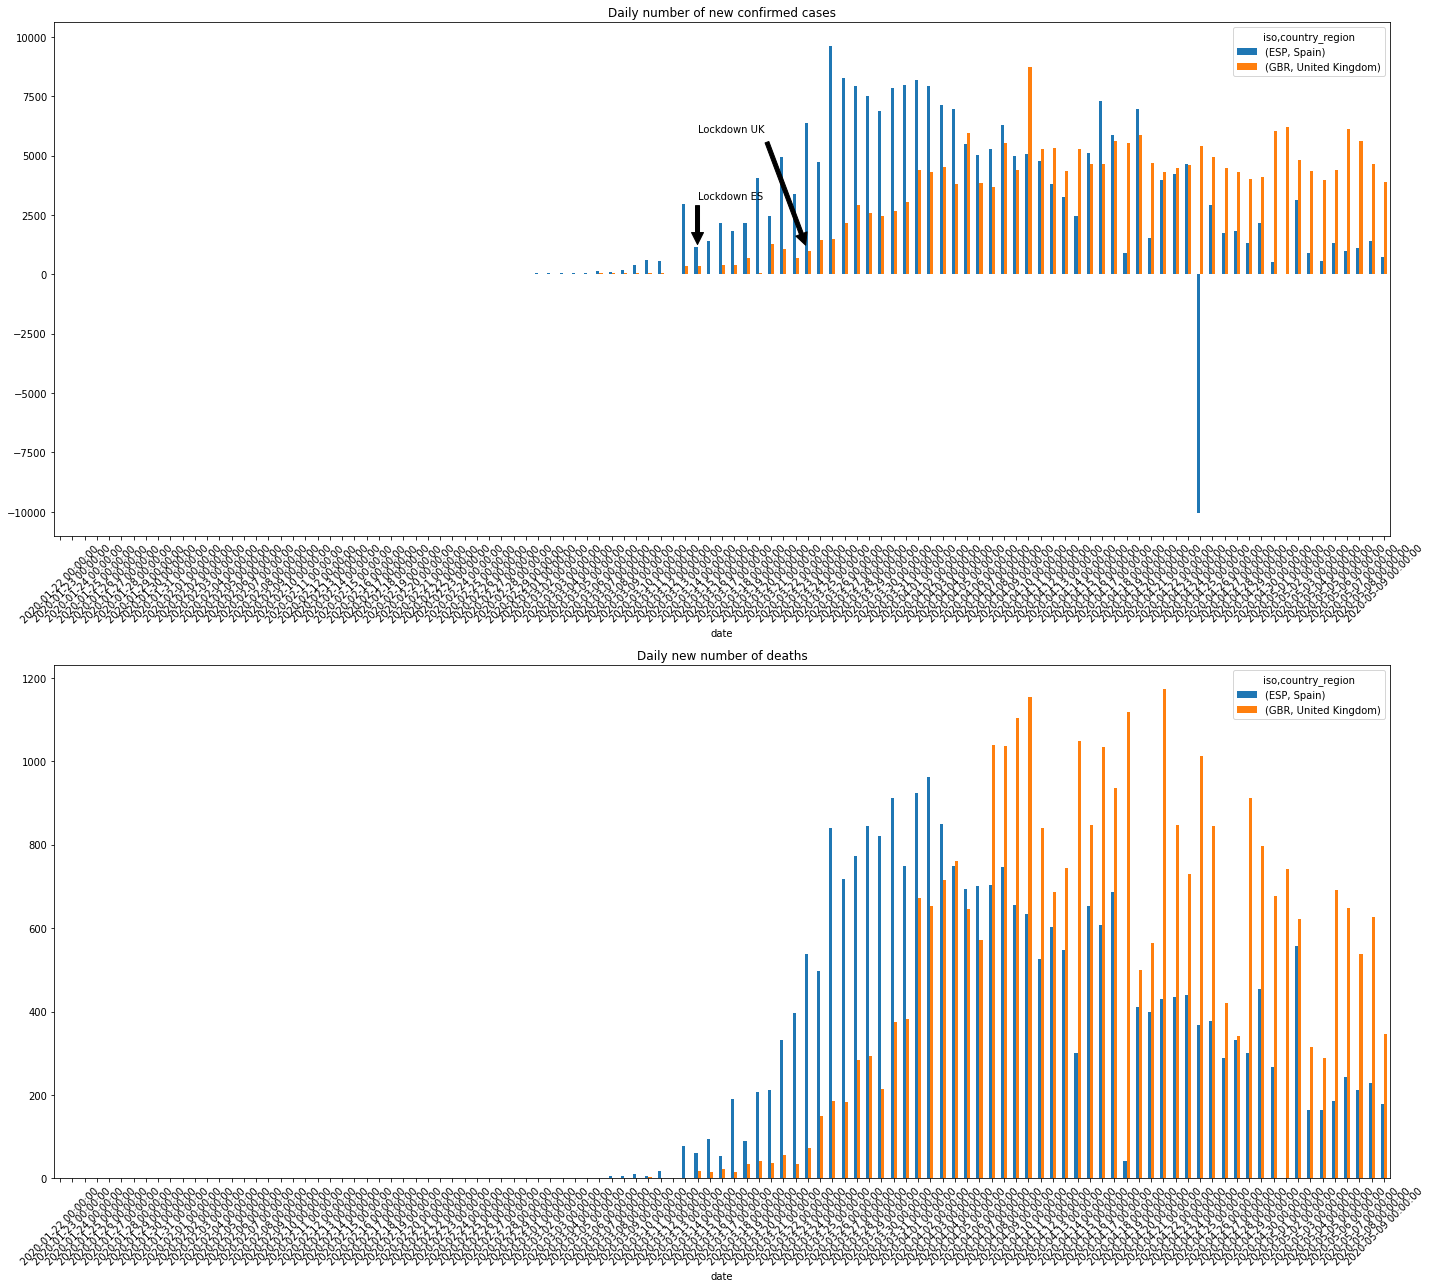

In [20]:
# Plot
fig, (top_ax, bottom_ax) = plt.subplots(2, 1, figsize=(20, 18))
abs_growth_confirmed.plot.bar(ax=top_ax, rot=45)
abs_growth_deaths.plot.bar(ax=bottom_ax, rot=45)
# plt.setp(top_ax.get_xticklabels()[::2], visible=False)
# plt.setp(bottom_ax.get_xticklabels()[::2], visible=False)
top_ax.set_title("Daily number of new confirmed cases")
top_ax.annotate(
    "Lockdown ES",
    xy=(idx_lockdown_ES, confirmed_on_lockdown_ES),
    xytext=(idx_lockdown_ES, confirmed_on_lockdown_ES + 2000),
    arrowprops=dict(facecolor="black", shrink=0.05),
)
top_ax.annotate(
    "Lockdown UK",
    xy=(idx_lockdown_UK, confirmed_on_lockdown_UK),
    xytext=(idx_lockdown_ES, confirmed_on_lockdown_UK + 5000),
    arrowprops=dict(facecolor="black", shrink=0.05),
)
bottom_ax.set_title("Daily new number of deaths")
plt.tight_layout()

### Predictive model: a simple approach

In [11]:
import numpy as np

NUM_DAYS = 17  # How many days ago, length of the window
# Build exponential weighting function


def exp_window(length=14, growth=1.1):
    window = growth ** np.arange(length)
    window = window / window.sum()
    return window

Text(0.5, 1.0, 'Weights over last 17 days.')

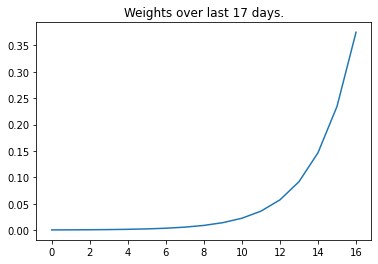

In [12]:
weighted_window = exp_window(length=NUM_DAYS, growth=1.6)
plt.figure()
plt.plot(weighted_window)
plt.title(f"Weights over last {NUM_DAYS} days.")

In [13]:
import pandas as pd

import statsmodels.api as sm

def fit_on_window(data, window):
    """ Fit the last window of the data
    """
    window_size = len(window)
    analysis_interval = data.iloc[-window_size:]
    log_analysis_interval = np.log(analysis_interval)
    log_analysis_interval[log_analysis_interval == -np.inf] = 0

    design = pd.DataFrame({'linear': np.arange(window_size),
                           'const': np.ones(window_size)})

    growth_rate = pd.DataFrame(data=np.zeros((1, len(data.columns))),
                               columns=data.columns)

    predicted_data = pd.DataFrame()
    predicted_data_lower = pd.DataFrame()
    predicted_data_upper = pd.DataFrame()
    prediction_dates = pd.date_range(data.index[-window_size],
                                    periods=window_size + 7)

    for country in data.columns:
        mod_wls = sm.WLS(log_analysis_interval[country].values, design,
                         weights=window, hasconst=True)
        res_wls = mod_wls.fit()
        growth_rate[country] = np.exp(res_wls.params.linear)
        predicted_data[country] = np.exp(res_wls.params.const +
                res_wls.params.linear * np.arange(len(prediction_dates))
            )
        # 1st and 3rd quartiles in the confidence intervals
        conf_int = res_wls.conf_int(alpha=.25)
        # We chose to account only for error in growth rate, and not in
        # baseline number of cases
        predicted_data_lower[country] = np.exp(res_wls.params.const +
                conf_int[0].linear * np.arange(len(prediction_dates))
            )
        predicted_data_upper[country] = np.exp(res_wls.params.const +
                conf_int[1].linear * np.arange(len(prediction_dates))
            )

    predicted_data = pd.concat(dict(prediction=predicted_data,
                                     lower_bound=predicted_data_lower,
                                     upper_bound=predicted_data_upper),
                                axis=1)
    predicted_data['date'] = prediction_dates
    predicted_data = predicted_data.set_index('date')
    if window_size > 10:
        # Don't show predictions more than 10 days ago
        predicted_data  = predicted_data.iloc[window_size - 10:]

    return growth_rate, predicted_data

#### Predicted Cases

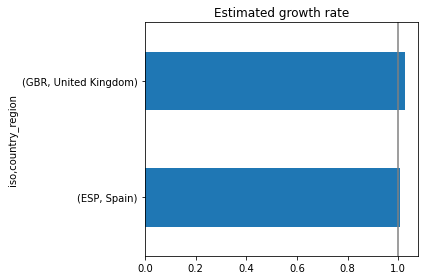

In [14]:
growth_rate, predicted_cases = fit_on_window(confirmed, weighted_window)

ax = growth_rate.T.plot(kind="barh", legend=False)
ax.set_title("Estimated growth rate")
ax.axvline(1, color=".5")
plt.tight_layout()

In [15]:
growth_rate

iso,ESP,GBR
country_region,Spain,United Kingdom
0,1.005097,1.024961


Text(0.5, 1.0, 'Number of confirmed cases in the last fortnight and prediction')

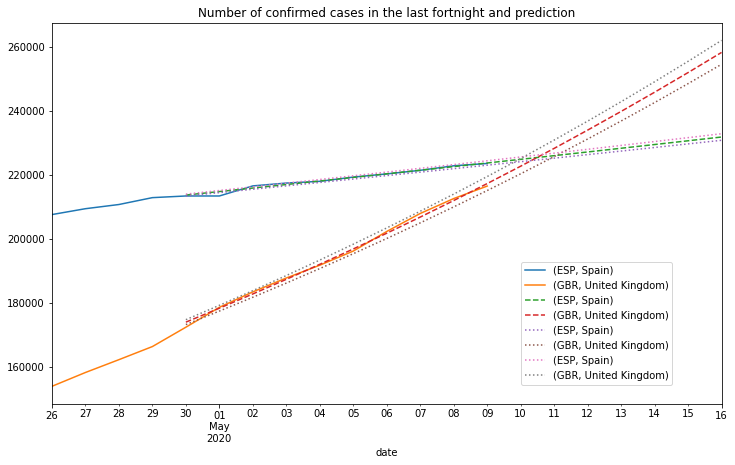

In [16]:
last_fortnight = confirmed.iloc[-14:]

ax = last_fortnight[countries_of_interest].plot(figsize=(12, 7))
predicted_cases["prediction"][countries_of_interest].plot(ax=ax, style="--")
predicted_cases["lower_bound"][countries_of_interest].plot(ax=ax, style=":")
predicted_cases["upper_bound"][countries_of_interest].plot(ax=ax, style=":")

plt.legend(loc=(0.7, 0.05))
ax.set_title("Number of confirmed cases in the last fortnight and prediction")

In [17]:
predicted_cases

prediction                          lower_bound  \
             (ESP, Spain) (GBR, United Kingdom)   (ESP, Spain)   
date                                                             
2020-04-30  213726.733752         174061.858936  213439.261467   
2020-05-01  214816.050307         178406.631833  214485.867798   
2020-05-02  215910.918862         182859.854976  215537.606198   
2020-05-03  217011.367713         187424.235401  216594.501831   
2020-05-04  218117.425301         192102.547715  217656.579986   
2020-05-05  219229.120213         196897.635782  218723.866075   
2020-05-06  220346.481181         201812.414450  219796.385637   
2020-05-07  221469.537085         206849.871328  220874.164333   
2020-05-08  222598.316948         212013.068596  221957.227952   
2020-05-09  223732.849946         217305.144871  223045.602408   
2020-05-10  224873.165401         222729.317113  224139.313743   
2020-05-11  226019.292784         228288.882581  225238.388128   
2020-05-12  227171.261717         233987.220836  226342.851859   
2020-05-13  228329.101975         239827.795798  227452.731364   
2020-05-14  229492.843480         245814.157850  228568.053199   
2020-05-15  230662.516312         251949.945995  229688.844051   
2020-05-16  231838.150700         258238.890071  230815.130738   

                                    upper_bound                        
           (GBR, United Kingdom)   (ESP, Spain) (GBR, United Kingdom)  
date                                                                   
2020-04-30         173298.000447  214014.593221         174829.084341  
2020-05-01         177512.140973  215146.741104         179305.630068  
2020-05-02         181828.758043  216284.878106         183896.798952  
2020-05-03         186250.343613  217429.035910         188605.525951  
2020-05-04         190779.450232  218579.246366         193434.821170  
2020-05-05         195418.692523  219735.541492         198387.771793  
2020-05-06         200170.748689  220897.953478         203467.544048  
2020-05-07         205038.362060  222066.514681         208677.385238  
2020-05-08         210024.342675  223241.257631         214020.625814  
2020-05-09         215131.568907  224422.215030         219500.681501  
2020-05-10         220362.989123  225609.419752         225121.055488  
2020-05-11         225721.623385  226802.904847         230885.340662  
2020-05-12         231210.565197  228002.703537         236797.221909  
2020-05-13         236832.983287  229208.849223         242860.478465  
2020-05-14         242592.123439  230421.375479         249078.986337  
2020-05-15         248491.310366  231640.316060         255456.720774  
2020-05-16         254533.949626  232865.704897         261997.758818

### Fatalities

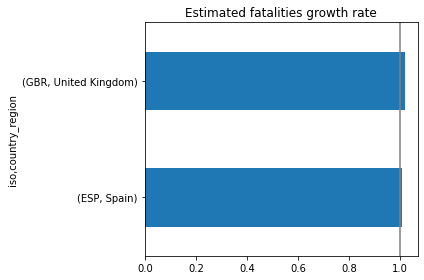

In [18]:
growth_rate, predicted_fatalities = fit_on_window(dead, weighted_window)

ax = growth_rate.T.plot(kind="barh", legend=False)
ax.set_title("Estimated fatalities growth rate")
ax.axvline(1, color=".5")
plt.tight_layout()

Text(0.5, 1.0, 'Number of confirmed fatalities in the last fortnight and prediction')

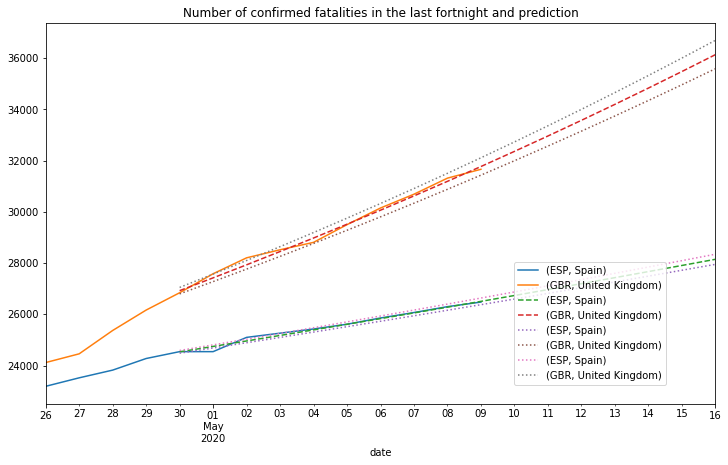

In [19]:
last_fortnight = dead.iloc[-14:]

ax = last_fortnight[countries_of_interest].plot(figsize=(12, 7))
predicted_fatalities["prediction"][countries_of_interest].plot(ax=ax, style="--")
predicted_fatalities["lower_bound"][countries_of_interest].plot(ax=ax, style=":")
predicted_fatalities["upper_bound"][countries_of_interest].plot(ax=ax, style=":")

plt.legend(loc=(0.7, 0.05))
ax.set_title("Number of confirmed fatalities in the last fortnight and prediction")